In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse.linalg
import matplotlib
matplotlib.rcParams['text.usetex'] = True


def CONSISTENCY(A1,B1,D1,A2,B2,D2):
    n1 = A1.shape[0]
    M1 = np.vstack([np.hstack([A1, B1.T]),
                    np.hstack([B1, D1])])
    M2 = np.vstack([np.hstack([D2, B2]),
                    np.hstack([B2.T, A2])])
    M = np.linalg.inv(M1)@M2.T
    evals, evecs = scipy.sparse.linalg.eigs(M,k=n1+n2,which='SM')
    idx = np.argsort(np.abs(evals))
    evals = evals[idx]
    print(evals)
    evecs = evecs[:,idx]
    Y,X = evecs[:n1,:n1], evecs[n1:,:n1]
    L = np.linalg.solve(Y.T,X.T).T#X@np.linalg.inv(Y)
    def LFT1(L):
        return -np.linalg.solve(A1+L.T@B1,B1.T+L.T@D1)
    def LFT2(G):
        return -np.linalg.solve(A2+G.T@B2,B2.T+G.T@D2)

    G = LFT1(L)  
    error = ''
    if not np.allclose(L,LFT2(G)):
        error += 'not a fixed point; '
    if not np.all(np.real(np.linalg.eigvals(np.vstack([np.hstack([A1, B1.T]),
                                   np.hstack([B2.T, A2])]))>0)):
        error += 'not stable in action space at nash; '

    eig1,_ = scipy.sparse.linalg.eigs(A1+L.T@B1,k=1,which='SR')
    eig2,_ = scipy.sparse.linalg.eigs(A2+G.T@B2,k=1,which='SR')
    if not np.all(np.real(np.hstack([eig1,eig2]))>0):
        error += 'not stable in action space; '
    if np.isclose((evals[n1-1]),np.conj(evals[n1])):
        error += 'conjugate pair in the gap; '

    if np.isclose(np.abs(evals[n1-1]),np.abs(evals[n1])):
        error += 'not stable in policy space; '
    else:
        print('gap:',np.abs(evals[n1])-np.abs(evals[n1-1]))
        #print('Warning! LFT unstable!', evals[n1-1], evals[n1])
        
    return (L,G,LFT1,LFT2),error

def grad(xi, xj, Li, A, B, D, b, d):
    return (A+Li.T@B)@xi + (B.T+Li.T@D)@xj + b + Li.T@d
    
def solve_eq(L, G, A1, B1, D1, b1, d1, A2, B2, D2, b2, d2):
    n1 = A1.shape[0]
    EQ = -np.linalg.solve(np.vstack([np.hstack([A1+L.T@B1,B1.T+L.T@D1]),
                                     np.hstack([B2.T+G.T@D2,A2+G.T@B2])]),
                          np.hstack([b1 + L.T@d1,
                                     b2 + G.T@d2]))
    return EQ[:n1], EQ[n1:]
def stochastic(INIT,A1,B1,D1,b1,d1,A2,B2,D2,b2,d2):

    T = 32
    seed = 0
    radius = 1
    sigma = 0.1
    lr = 1

    n1 = 2
    n2 = 3
    def r1(x1,x2,L,K=64,lr=0.1):
        for k in range(K):
            x1 = x1 - lr*((A1+L.T@B1)@x1 + (B1.T+L.T@D1)@x2 + (b1 + L.T@d1))
        return x1

    def r2(x1,x2,G,K=64,lr=0.1):
        for k in range(K):
            x2 = x2 - lr*((A2+G.T@B2)@x2 + (B2.T+G.T@D2)@x1 + (b2 + G.T@d2))
        return x2
    DATA = []
    for seed in range(20):
        np.random.seed(seed)
        w1 = np.random.randn(n2,n1)
        w2 = np.random.randn(n1,n2)

        w1 /= np.linalg.norm(w1)
        w2 /= np.linalg.norm(w2)

        x1_ = np.zeros((T,n1))
        x2_ = np.zeros((T,n2))

        L_, G_ = np.zeros((T,n2,n1)), np.zeros((T,n1,n2))

        x1_[0],x2_[0] = INIT
        L_[0] = np.real(L) + radius*w1
        G_[0] = np.real(G) + radius*w2

        for t in range(T-1):
            x1, x2 = x1_[t], x2_[t]

            # Player 1:
            dx1 = sigma**2*np.random.randn(n1)
            dx2 = r2(x1+dx1, x2, G_[t]) - r2(x1, x2, G_[t])
            dL = np.outer(dx2-L_[t]@dx1, dx1)/np.sum(dx1**2)
            L_[t+1] = L_[t] + lr*dL
            x1_[t+1] = r1(x1, x2, L_[t], K=1)

            # Player 2:
            dx2 = np.random.randn(n2)
            dx2 = sigma**2*dx2/np.sum(dx2**2)
            dx1 = r1(x1, x2+dx2, L_[t]) - r1(x1, x2, L_[t])
            dG = np.outer(dx1-G_[t]@dx2, dx2)/np.sum(dx2**2)
            G_[t+1] = G_[t] + lr*dG
            x2_[t+1] = r2(x1, x2, G_[t], K=1)

        LL_ = np.zeros((T,n2,n1))    
        GG_ = np.zeros((T,n1,n2))

        LL_[0] = np.real(L) + radius*w1/np.linalg.norm(w1)
        GG_[0] = np.real(G) + radius*w2/np.linalg.norm(w2)

        for t in range(T-1):
            LL_[t+1] = LFT2(LFT1(LL_[t]))
            GG_[t+1] = LFT1(LFT2(GG_[t]))


        Lerr = np.linalg.norm(L_-L,axis=(1,2))
        LLerr = np.linalg.norm(LL_-L,axis=(1,2))

        Gerr = np.linalg.norm(G_-G,axis=(1,2))
        GGerr = np.linalg.norm(GG_-G,axis=(1,2))

        DATA.append(np.array([[seed]*T,range(T),x1_[:,0],x1_[:,1],Lerr,LLerr,Gerr,GGerr]).T)
    DATA = np.array(DATA)
    df = pd.DataFrame(DATA.reshape(-1,8),columns=['seed','t','x11','x12','Lerr','LLerr','Gerr','GGerr'])
    #plt.yscale('log')
    return df

seed = 0
np.random.seed(seed)
A1 = np.eye(2)
B1 = np.round(np.random.rand(3,2),1)
D1 = -0.25*np.eye(3)
b1 = np.zeros(2)
d1 = np.zeros(3)

A2 = np.eye(3)
B2 = -np.round(np.random.rand(2,3),1)
D2 = -1/8*np.eye(2)

b2 = np.ones(3)
d2 = np.ones(2)

n1 = 2
n2 = 3
print(seed)
(L,G,LFT1,LFT2),error=CONSISTENCY(A1,B1,D1,A2,B2,D2)
if error:
    print(error)
    
assert np.allclose(L,LFT2(G)) and np.allclose(G, LFT1(L))
LFT = lambda L: LFT2(LFT1(L))
L,G
Lopt = np.copy(L)
CCVE = solve_eq(L,G,A1,B1,D1,b1,d1,A2,B2,D2,b2,d2)
NE = solve_eq(np.zeros((n2,n1)),np.zeros((n1,n2)),A1,B1,D1,b1,d1,A2,B2,D2,b2,d2)

ccve1,ccve2 = CCVE

def sim(x0,L0,A1,B1,D1,b1,d1,A2,B2,D2,b2,d2):
    K = 20
    T = 50
    lr1,lr2 = 0.1,0.1

    n1 = A1.shape[0]
    n2 = A2.shape[0]

    x1 = np.zeros((K,T,n1))
    x2 = np.zeros((K,T,n2))
    L1 = np.zeros((K,n2,n1))
    L2 = np.zeros((K,n1,n2))
    x1[0],x2[0] = x0
    L1[0],L2[0] = L0

    for k in range(K):
        for t in range(T-1):
            #x1[k,t+1] = x1[k,t] - lr1*grad(x1[k,t],x2[k,t],L1[k],A1,B1,D1,b1,d1)
            #x2[k,t+1] = x2[k,t] - lr2*grad(x2[k,t],x1[k,t],L2[k],A2,B2,D2,b2,d2)
            x1[k,t+1],x2[k,t+1] = solve_eq(L1[k],L2[k],A1,B1,D1,b1,d1,A2,B2,D2,b2,d2)
        if k == K-1: break

        if k%2==1:
            L2[k+1] = LFT1(L1[k])
            L1[k+1] = L1[k]
        else:
            L1[k+1] = LFT2(L2[k])
            L2[k+1] = L2[k]
        x1[k+1,0] = x1[k,-1]
        x2[k+1,0] = x2[k,-1]
    return (x1,x2,L1,L2)

x0 = (np.zeros(n1),np.zeros(n2))
L0 = (np.zeros((n2,n1)),np.zeros((n1,n2)))
x1,x2,L1,L2 = sim(x0,L0,A1,B1,D1,b1,d1,A2,B2,D2,b2,d2)

x1,x2
if np.all(np.abs(x1)<1) and np.all(np.abs(x2)<1):
    print('well behaved')
    print(A1)
    print(B1)
    print(D1)
    print(b1,d1)

    print(A2)
    print("-",-B2.T)
    print(D2)
    print(b2,d2)
    
    
np.all(np.abs(x1)<10)

0
[-0.19017522+0.j -0.88440397+0.j -1.67282008+0.j -3.38606372+0.j
 -4.        +0.j]
gap: 0.7884161104561058
well behaved
[[1. 0.]
 [0. 1.]]
[[0.5 0.7]
 [0.6 0.5]
 [0.4 0.6]]
[[-0.25 -0.   -0.  ]
 [-0.   -0.25 -0.  ]
 [-0.   -0.   -0.25]]
[0. 0.] [0. 0. 0.]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
- [[0.4 0.4]
 [0.9 0.8]
 [1.  0.5]]
[[-0.125 -0.   ]
 [-0.    -0.125]]
[1. 1. 1.] [1. 1.]


/usr/local/anaconda3/lib/python3.9/site-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1265: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  warnings.warn("k >= N - 1 for N * N square matrix. "


True

In [2]:
from cycler import cycler

default_cycler = (cycler(color=['#332288','#117733','#44AA99','#88CCEE',
                                '#CC6677','#AA4499','#882255']))

plt.rc('lines', linewidth=1.5)
plt.rc('axes', prop_cycle=default_cycler)


/var/folders/8_/x321bsw568557jdlpktql26h0000gn/T/ipykernel_64588/4068567169.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ok" (-> color='k'). The keyword argument will take precedence.
  ax.plot(*x1[:,-1].T,'ok',markeredgecolor='w',ms=3,markeredgewidth=.5,color='k',label='CVE',zorder=11)


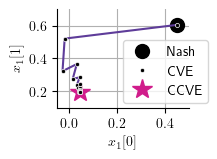

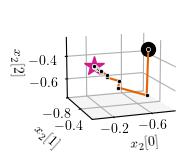

In [3]:
FIGSIZE = np.array([1.7]*2)

COLORX = '#5e3c99'
COLORY = '#e66101'
COLORC = "#d01c8b"
COLORN = 'black'
ms = 10
MS = 15

# ACTION PLOT x1
fig,ax = plt.subplots(figsize=FIGSIZE*np.array([1,0.75]))

ax.plot(*NE[0],'o',ms=ms,color=COLORN,label='Nash')
ax.plot(*x1[1:].reshape(-1,n1).T,color=COLORX,zorder=10)
ax.plot(*x1[:,-1].T,'ok',markeredgecolor='w',ms=3,markeredgewidth=.5,color='k',label='CVE',zorder=11)
ax.plot(*CCVE[0],'*',ms=MS,color=COLORC,label='CCVE',zorder=3)

ax.set_xlabel(xlabel='$x_{1}[0]$')#,labelpad=-5)
ax.set_ylabel(ylabel='$x_{1}[1]$')#,labelpad=-5)

#ax.set(xticks=[CCVE[0][0]],yticks=[CCVE[0][1]])
#ax.set(xticklabels=[],yticklabels=[])
ax.spines.top.set_visible(False)
ax.spines.right.set_visible(False)
ax.legend(loc=4,bbox_to_anchor=(1.2, -0.02))
ax.set(xlim=[-0.05,.5],ylim=[0.1,0.7],zorder=-11)
ax.grid()
fig.savefig('2023lcss-2x3-phase-x1.pdf',bbox_inches='tight')

# ACTION PLOT x2
fig = plt.figure(figsize=FIGSIZE*np.array([1,1.5]))
ax = fig.add_subplot(1,1,1,projection='3d')

ax.plot(*NE[1],'o',ms=ms,color=COLORN)
ax.plot(*CCVE[1],'*',ms=MS,color=COLORC)
ax.plot(*x2[1:].reshape(-1,n2).T,color=COLORY)
ax.plot(*x2[:,-1].reshape(-1,n2).T,'o',ms=3,markeredgewidth=.5,markeredgecolor='w',color='k')
ax.set_xlabel(xlabel='$x_2[0]$', rotation=0, labelpad=-6)
ax.set_ylabel(ylabel='$x_2[1]$', rotation=0, labelpad=-1)
ax.set_zlabel(zlabel='$x_2[2]$', rotation=0, labelpad=4)

ax.set(xticks=[-0.2, -0.6])
ax.set(yticks=[-0.4, -0.8])
#ax.set(xticks=[CCVE[1][0]],yticks=[CCVE[1][1]],zticks=[CCVE[1][2]])
#ax.set(xticklabels=[],yticklabels=[],zticklabels=[])

elev = 13
azim = 70
roll = 'z'
ax.view_init(elev, azim, roll)
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.tick_params(axis='x', which='major', pad=-5)
ax.tick_params(axis='y', which='major', pad=-1)

fig.savefig('2023lcss-2x3-phase-x2.pdf',bbox_inches='tight')


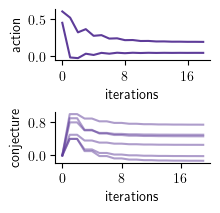

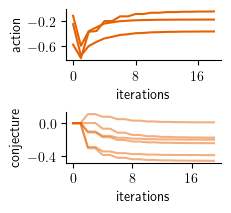

In [4]:
fig,axs = plt.subplots(figsize=(2,2),nrows=2,gridspec_kw=dict(hspace=1))

axs[0].set(ylabel='action')
axs[0].set(xlabel='iterations')
axs[0].plot(x1[:-1,1:2:].reshape(-1,n1),color=COLORX)
#axs[0].set(ylim=[-1.2,1.2])
axs[0].spines.top.set_visible(False)
axs[0].spines.right.set_visible(False)
axs[0].set(xticks=range(0,20,8))

axs[1].set(ylabel='conjecture')
axs[1].set(xlabel='iterations')
axs[1].plot(range(len(L1)),L1.reshape(-1,n1*n2),color=COLORX,alpha=0.5)#,where='post')
#axs[1].set(ylim=[-1.8,1.5])
axs[1].spines.top.set_visible(False)
axs[1].spines.right.set_visible(False)
axs[1].set(yticks=[0,0.8])
axs[1].set(yticks=[0,0.8])
axs[1].set(xticks=range(0,20,8))
fig.savefig('2023lcss-2x3-act-conj-p1.pdf',bbox_inches='tight')

plt.show()

fig,axs = plt.subplots(figsize=(2,2),nrows=2,gridspec_kw=dict(hspace=1))

axs[0].set(ylabel='action')
axs[0].set(xlabel='iterations')
axs[0].plot(x2[:-1,1:2:].reshape(-1,n2),color=COLORY)
#axs[0].set(ylim=[-1.2,1.2])
axs[0].spines.top.set_visible(False)
axs[0].spines.right.set_visible(False)
axs[0].set(yticks=[-.2,-.6])
axs[0].set(xticks=range(0,20,8))

axs[1].set(ylabel='conjecture')
axs[1].set(xlabel='iterations')
axs[1].plot(range(len(L2)),L2.reshape(-1,n1*n2),color=COLORY,alpha=0.5)#,where='post')
#axs[1].set(ylim=[-1.3,1.3])
axs[1].spines.top.set_visible(False)
axs[1].spines.right.set_visible(False)
axs[1].set(yticks=[-.4,-0])
axs[1].set(xticks=range(0,20,8))

fig.savefig('2023lcss-2x3-act-conj-p2.pdf',bbox_inches='tight')

plt.show()